In [22]:
import qtensor
import xarray as xar
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys
sys.path.append('../data/generators/')
import miplog_helper

In [23]:
def to_mh(item) -> miplog_helper.MiplogData:
    starts, *diffs = item
    return miplog_helper.MiplogData.from_start_and_diffs(starts, diffs)

In [24]:
def get_data_match_deg(gurobi_preset):
    data_match_deg = {}
    data_match_deg[3] = pickle.load(open(f'../data/gurobi_match_d3_gp{gurobi_preset}.pkl', 'rb'))
    data_match_deg[4] = pickle.load(open(f'../data/gurobi_match_d4_gp{gurobi_preset}.pkl', 'rb'))
    data_match_deg[5] = pickle.load(open(f'../data/gurobi_match_d5_gp{gurobi_preset}.pkl', 'rb'))
    return data_match_deg

In [25]:
def get_colors(n, cm=plt.cm.gnuplot2, offset=0.2):
    return [cm(offset + x*(1-2*offset)) for x in np.linspace(0, 1, n)]

In [26]:
def approx_ratio(p, degree):
    ps = [qtensor.tools.BETHE_QAOA_VALUES[str(p)]['val'] for p in range(1, 12)]
    try:
        AR = ps[p-1]
        if AR<0:
            raise KeyError
    except (KeyError, IndexError):
        last_2 = ps[-2:]
        dif = last_2[1] - last_2[0]
        dif *= .7
        AR = last_2[1] + dif*(p-11)
        
    if degree==4:
        AR *= 0.94
    
    if degree==5:
        AR *= 0.90
        
    return AR

def get_data_AR_lower(data, AR, nan_repl=None):
    times =  xar.apply_ufunc(lambda x: to_mh(x).get_time_for_AR_lower(AR)[0], data, vectorize=True)
    ftimes = times.astype(np.float)
    ftimes.data[np.isnan(ftimes.data)] = nan_repl or np.nan
    return ftimes

def get_data_AR_upper(data, AR, nan_repl=None):
    times =  xar.apply_ufunc(lambda x: to_mh(x).get_time_for_AR_upper(AR)[0], data, vectorize=True)
    ftimes = times.astype(np.float)
    ftimes.data[np.isnan(ftimes.data)] = nan_repl or np.nan
    return ftimes

In [27]:
data_match_deg = get_data_match_deg('default')

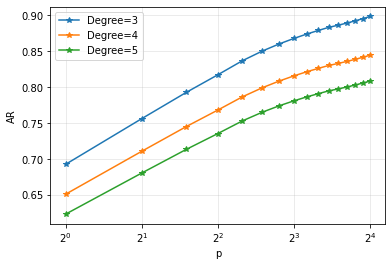

In [28]:
## Approx ratio extrapolation

ps = range(1, 17)
for deg in data_match_deg.keys():
    ars = [approx_ratio(p, degree=deg) for p in ps]


    plt.plot(np.array(ps), ars, '*-', label=f'Degree={deg}')
    plt.xscale('log', base=2)
    plt.xlabel('p')
    plt.ylabel('AR')
    plt.grid(alpha=.3)
    plt.legend()

In [29]:
def get_fixed_angles():
    import requests
    req = requests.get('https://raw.githubusercontent.com/danlkv/fixed-angle-QAOA/master/angles_regular_graphs.json')
    if req.ok:
        fixed_angles = req.json()
    else:
        raise Exception('Failed to download fixed angles! Error:'+req.text)
    return fixed_angles
fixed_angles = get_fixed_angles()

In [30]:
def first_datapoint(lst):
    mh = to_mh(lst)
    miplog = mh.miplog
    for t, ub, lb in miplog:
        if lb > 0:
            return dict(time=t, ub=ub, lb=lb)

In [31]:
gurobi_preset = 'default'
data_match_deg = get_data_match_deg(gurobi_preset)
data_match_deg[3].coords

Coordinates:
  * N        (N) int64 30 100 150 1000 1400 ... 12400 15000 40000 50000 100000
  * seed     (seed) int64 10 11 12 13 14 15 16 17 18 19

In [49]:
def plot_data_match_deg(data_match_deg, fixed_angles):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    degrees = data_match_deg.keys()
    colors = iter(get_colors(len(degrees)))

    for conn in degrees:
        data_match = data_match_deg[conn]
        first_dps = xar.apply_ufunc(first_datapoint, data_match, vectorize=True)
        tms = xar.apply_ufunc(lambda x: x['time'], first_dps, vectorize=True)
        lbs = xar.apply_ufunc(lambda x: x['lb'], first_dps, vectorize=True)
        c = next(colors)
        plt.sca(axs[0])
        plt.title('Time for first datapoint')
        plt.plot(first_dps.N, tms.median('seed'), '*-',
                 label=f'Degree={conn}', color=c)
        plt.grid(alpha=.5)
        plt.legend()

        plt.sca(axs[1])
        plt.title('Cut fraction at first datapoint')
        plt.plot(first_dps.N, lbs.mean('seed')/first_dps.N/conn*2, color=c)


        best_ar_guarantee = list(fixed_angles[str(conn)].values())[-1]['AR']
        best_ar_p = list(fixed_angles[str(conn)].keys())[-1]
        plt.hlines(best_ar_guarantee, min(first_dps.N), max(first_dps.N),
                   label=f'degree={conn}', color=c, linewidth=1, linestyle='--')
        plt.text(x=max(first_dps.N), y=best_ar_guarantee+.003, s=f'p={best_ar_p}',
                 horizontalalignment='right',
                 color=c
                )
    plt.legend(title=f'QAOA best known\nguarantee', loc='lower left')
    plt.grid(alpha=.5)
    plt.xscale('log')
    plt.xlabel('$N$')
    plt.ylabel('Cut fraction at $T_0$')
    plt.title(None)
    plt.sca(axs[0])
    plt.xlabel('$N$')
    plt.title(None)
    plt.ylabel('$T_0$')

    #plt.suptitle('Gurobi first datapoint performance')

In [50]:
fixed_angles = get_fixed_angles()

symLin2


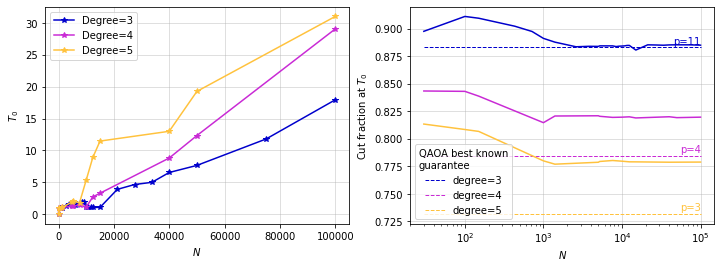

In [51]:
data_match_deg = {}
data_match_deg[3] = pickle.load(open(f'../data/gurobi_match.pkl', 'rb'))
data_match_deg[4] = pickle.load(open(f'../data/gurobi_match_d4.pkl', 'rb'))
data_match_deg[5] = pickle.load(open(f'../data/gurobi_match_d5.pkl', 'rb'))
plot_data_match_deg(data_match_deg, fixed_angles)
plt.savefig('./pdf/t0_gurobi_vs_degree.pdf')
print('symLin2')

default


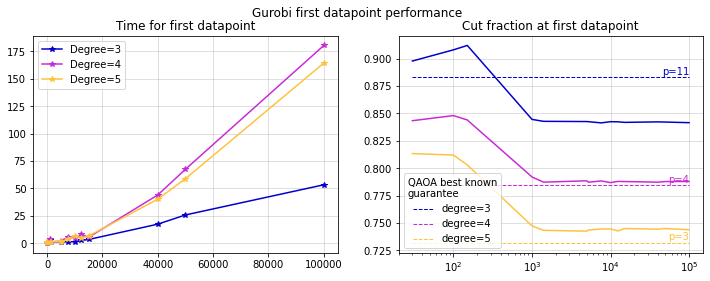

In [35]:
presets = ['default']#, 'symLin0', 'SymPre2']
print('default')
for gurobi_preset in presets:
    data_match = get_data_match_deg(gurobi_preset)
    plot_data_match_deg(data_match, fixed_angles)

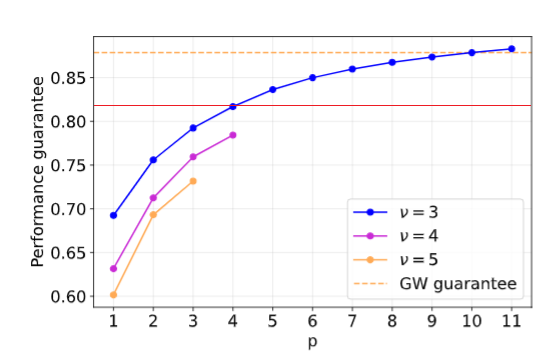